# Single-voxel test

This notebook will show some of the functionality of a single voxel instances.

 1. The first example will examine a simple instance of a clump with only a few observed velocities. This example is fully worked-out with explanations for some of the steps hidden inside the voxel setup. It is compared to the analytical result to ensure accuracy, then repeated using more model velocities to show how the model becomes more accurate.
 2. Next it will be shown how absorption within the voxel is handled. A couple of examples will be given highlighting different scenarios where there are different numbers of clumps in a line-of-sight. These begin by evaluating the model, then the result is analytically approximated to show the accuracy.
 3. An example will be given to test the effect of the observed velocity dispersion on intensity.
 4. An example showcasing the ability of the voxel to be resized in order to fit the largest clump. It still uses a simple model with just one clump mass, but will test the effect of changing how the intensity is calculated.
 5. An example using multiple clump masses and showing how it affects the overall voxel emission. Here we repeat a previous example and just change which clump masses we use.
 6. Finally an example showing how using a much higher clump mass in a larger voxel affects the intensity and optical depth. It uses the same model as the previous example, but changes the input clump mass and voxel resolution. The object is to show how increasing the resolution (voxel size) and clump mass will yield the same result.

## 

## Theoretical basis

We need to ensure that we can replicate the intensity and optical depth that we would expect from a $10 \ M_\odot$ clump in the voxel. In order to do that, let us consider the $C^+ \ 1 \rightarrow 0$ and $^{13}C^+ \ 1 \rightarrow 0$ transitions and the first dust line. In the radiative transfer equation,

(1)$$
dI_\nu = - I_\nu \kappa_\nu ds + \epsilon_nu ds,
$$

we can assume $\kappa$ and $\epsilon$ (the absorption and emissivity coefficients, respectively) are constant in the voxel. Therefore they are calculated using the voxel-averaged emmision:

(2)$$
\epsilon_\nu (v_{obs}) = \frac{\left<I_\nu\right> (v_{obs})}{\Delta s},
$$

(3)$$
\kappa_\nu (v_{obs}) = \frac{\left<\tau_\nu\right> (v_{obs})}{\Delta s},
$$

In order to properly understand these voxel-averaged values, it is necessary to have some insight for what is happening inside the voxel. The clumpy PDR is approximated by an ensemble of spherically-symetric KOSMA-$\tau$ 'clumps'. The ensemble of clumps has a Gaussian velocity distribution with dispersion $\sigma_{ens}$, and each clump has an intrinsic velocity dispersion $\sigma_{cl}$ (this value depends on which underlying KOSMA-$\tau$ grid is used, but currently it is $\sim0.71 \frac{km}{s}$). The number of clumps with a particular mass ($N_j$) follows the mass spectrum:

(4)$$
\frac{\mathrm{d}N}{\mathrm{d}M} = A M^{-\alpha}
$$

Here we adopt $\alpha=1.84$ from Heithausen et al. (1998), and $A$ is a constant. Henceforth the subscript $j$ will refer to a property specific for clumps with mass $M_j$. Clumps can be observed with a particular radial velocity, so we also use the formalism of the subscript $i$ to refer to a property with radial velocity $v_i$. Note that this is a velocity within the voxel, not the observed velocity. The observed radial velocity is $v_{obs}$.

Now the number of clumps with a particular radial velocity $v_i$ is determined by the number of clumps of a particular mass $N_j$ and velocity distribution of the ensemble $\sigma_{ens}$.

(5)$$
\Delta N_{j,i} (v_{obs}) = \frac{N_j}{\sqrt{2 \pi} \sigma_{ens}} \ \mathrm{exp} \left( -\frac{(v_{vox}-v_i)^2}{2 \sigma_{ens}} \right) \Delta v
$$

$p_{j,i}$ is the probability of having $k_{j,i}$ clumps in a line-of-sight observed at velocity $v_i$, determined by Binomial distribution of the number of clumps at that velocity:

(6)$$
p_{j,i} = \binom{N_{j,i}}{k_{j,i}} p_j^{k_{j,i}} (1-p_j)^{N_{j,i}-k_{j,i}}
$$

Where $p_j$ is the area fraction of clump $j$. If $p_j N_{j,i}>5$, then a gaussian expression is used with $\mu_{j,i} = p_j N_{j,i}$ and $\sigma_{j,i} = \sqrt{N_{j,i} p_j (1-p_j)}$.

For having $k_{j,i}$ clumps in a line-of-sight, the intensity and optical depth ($I_{\nu,j,i}$ \& $\tau_{\nu,j,i}$) can be calculated. Here the subscript $\nu$ means the properties refer to a particular transition (which is what we get from the KOSMA-$\tau$ grid). 

(7)$$
I_{\nu,j,i} (v_{obs}) = k_{j,i} I_{cl,j} \mathrm{exp} \left( \frac{(v_i-v_{obs})^2}{2\sigma_{cl}^2} \right)
$$

(8)$$
\tau_{\nu,j,i} (v_{obs}) = k_{j,i} \tau_{cl,j} \mathrm{exp} \left( \frac{(v_i-v_{obs})^2}{2\sigma_{cl}^2} \right)
$$

Finally the intensity and optical depth can be averaged over the voxel using all possible combinations and their corresponding probabilities to determine voxel properties we require.

(9)$$
\left< I_\nu \right> (v_{obs}) = \sum_i \left( \prod_j p_{j,i}(k_{j,i}) \right) \left( \sum_j k_{j,i} I_{\nu,j,i} (v_{obs}) \right)
$$

(10)$$
\left< \tau_\nu \right> (v_{obs}) = -\mathrm{ln} \left[ \sum_i \left( \prod_j p_{j,i}(k_{j,i}) \right) \ \mathrm{exp} \left( - \sum_j k_{j,i} \tau_{\nu,j,i} (v_{obs}) \right) \right]
$$

Here the sums and products ensure we consider contributions from all clump masses at all radial velocities, since there is a velocity dispersion to each clump's intensity and opticalo depth. Now we can finally substitute these into the radiative transfer equation to determine the intensity we expect to observe from this voxel.

(11)$$
I_{\mathrm{vox},\nu} (v_{obs}) = \frac{\epsilon_\nu (v_{obs})}{\kappa_\nu (v_{obs})} \left( 1 - e^{-\kappa_\nu (v_{obs}) \Delta s} \right) + I_{bg} e^{-\kappa_\nu (v_{obs}) \Delta s}
$$

# 1. Simple voxel

## Model result

We want to consider a small mass of clumps in a reasonably-large voxel. The instance can be initialised easily, but the voxel properties will require kwargs. The full list of kwargs can be seen in `Voxel.py`. We will define the kwargs as `parameters` for convenience, since it contains all of the arguments needed for setting the model and thus how the intensity and optical depth are calculated. At the moment this is a very long dictionary, so please let me know if you have any suggestions to make this simpler. It currently shows which kwargs affect the model and which kwargs set the actual voxel properties.

Model Parameters
 - `voxel_size`: The size in parsecs of the voxel. The default is $1pc$.
 - `molecules`: This is a list of the species transitions included in the model. At the moment this is a string with '[molecule] [transition]'. The default is 'all' to include all species and transitions.
 - `alpha`: The exponent used in the mass spectrum power law for the clumps. The default is 1.84 as in Heithausen (1995).
 - `gamma`: The exponent used in the mass-radius power law for the clumps. The default is 2.31 as in Heithausen (1995).
 - `clumpMassRange`: KOSMA-$\tau^3$ accepts a list of clump types to be included in the model. The argument supplied here therefore is a list of clump mass ranges, specified in $dex(M_\odot)$. The values are interpolated from the KOSMA-$\tau$ grid included with this package, which covers the range $[-3, 3] \ dex$. By default this is [[0, 2], [-2]] to model the clump and diffuse interclump regions.
 - `clumpMassNumber`: This specifies the number of different clump masses in the model. This should be a list with the length of the number of clump sets you want modelled. By default it is [3,1].
 - `clumpNmax`: This is used for normalising the number of clumps that are calculated. This should be a list with the length of the number of clump sets you want modelled. If a float or int is given, that is the value used for each clump set. By default it is set to [1,100]
 - `velocityRange`: The range of observing velocities in the model, in $\frac{km}{s}$. By default it is set to $[-10, 10]$. This does not affect the internal system velocities.
 - `velocityNumber`: The number of observing velocities in `velocityRange`. By default it is set to $201$. This does not affect the internal system velocities.
 
Voxel Properties
 - `velocity`: The mean radial velocity of the clumps in the voxel in $\frac{km}{s}$. The default is $0 \frac{km}{s}$.
 - `ensembleDispersion`: The velocity dispersion of the ensemble of clumps in the voxel. This should be a list with the length of the number of clump sets you want modelled. If a float or int is given, that is the value used for each clump set. giving a value of $0$ will create all clumps at one observing velocity. The default is $[2, 5] \ \frac{km}{s}$.
 - `clumpMass`: The clump mass to be modeled in the voxel in $M_\odot$. This should be a list with the length of the number of clump sets you want modelled. If a float or int is given, that is the value used for each clump set. The default is $100 \ M_\odot$.
 - `ensembleDensity`: The mean ensemble density in $cm^{-3}$ of the voxel, which is used to calculate the density of each clump. This should be a list with the length of the number of clump sets you want modelled. If a float or int is given, that is the value used for each clump set. These are interpolated from the KOSMA-$\tau$ grid included with this package, which covers the range $[10^3, 10^7] \ cm^{-3}$. The default is $[15000, 1911] \ cm^{-3}$.
 - `FUV`: The FUV radiation in Draine units of the voxel. This should be a list with the length of the number of clump sets you want modelled. If a float or int is given, that is the value used for each clump set. These are interpolated from the KOSMA-$\tau$ grid included with this package, which covers the range $[10^0, 10^6] \ \chi_0$. The default is $[20000, 1] \ \chi_0$.

The voxel we want to make will only have one observing velocity and one clump mass so there is only one clump in the ensemble. For now we do not need more than one clump set, so the lists in model parameters for ensemble velocity dispersion, clump mass, ensemble density, and FUV radiation should all have length $1$. The ensemble density and FUV radiation of the voxel is $10^5 \ cm^{-3}$ and $10^4 \ \chi_0$, respectively. We want to create just one $10 \ M_\odot$ clump, so we use an ensemble velocity dispersion of $0 \ \frac{km}{s}$. After these values are set accordingly, unpack and pass the `parameters` disctionary to the `Voxel.setProperties` method.

In [1]:
from kosmatau3d import models
import numpy as np

# Use these to change the voxel properties, which is necessary in the default mode.
parameters = { \
                # Model parameters
                'voxel_size' : 1, \
                 'molecules' : 'all', \
                      'dust' : 'PAH', \
            'clumpMassRange' : [[1]], \
           'clumpMassNumber' : [1], \
                 'clumpNmax' : [1], \
             'velocityRange' : [-10, 10], \
            'velocityNumber' : 201, \

                # Voxel properties
                  'velocity' : 0., \
        'ensembleDispersion' : 0, \
                 'clumpMass' : 10, \
           'ensembleDensity' : 1e5, \
                       'FUV' : 1e4 \
          }

vox = models.Voxel()
vox.setProperties(**parameters)

Here we can verify that we are modelling an appropriate clump mass. These should be exactly the same since there is no velocity dispersion.

In [2]:
vox.getClumpMass() #mass of the clumps to be modelled in M_sol. This is merely the input given to vox.setProperties().

[10]

In [3]:
vox.getModelMass() #mass of the clumps that have been modelled in M_sol. This is the mass of the voxel represented in clumps, which may differ from the input due to discretisation.

[9.999999999999998]

That works fine. It is important to note that there are numerous things going on in this method, such as

 - setting the voxel properties (mass, density, FUV field),
 - reading the molecules available on the grid,
 - determining the intensity (in K) and optical depth from each clump in the model,
 - calculating how many clumps are at each observed radial velocity,
 - and calculating the clump combinations
 
We can check all of these directly from their corresponding sub-modules. To check the model parameters, examine the `constants` sub-module (so-called since it contains values constant in the model, not values that are always constant). We can verify our model clumps, observed velocities, and check which species transitions and dust wavelengths we can calculate. Note that the clump properties are lists since you can evaluate more than one set of clumps. We only evaluated one set, so we only need the first (only) element.

In [4]:
models.constants.clumpLogMass[0] #in dex(M_sol)

array([[1.]])

In [5]:
models.constants.velocityRange #in km/s

array([-10. ,  -9.9,  -9.8,  -9.7,  -9.6,  -9.5,  -9.4,  -9.3,  -9.2,
        -9.1,  -9. ,  -8.9,  -8.8,  -8.7,  -8.6,  -8.5,  -8.4,  -8.3,
        -8.2,  -8.1,  -8. ,  -7.9,  -7.8,  -7.7,  -7.6,  -7.5,  -7.4,
        -7.3,  -7.2,  -7.1,  -7. ,  -6.9,  -6.8,  -6.7,  -6.6,  -6.5,
        -6.4,  -6.3,  -6.2,  -6.1,  -6. ,  -5.9,  -5.8,  -5.7,  -5.6,
        -5.5,  -5.4,  -5.3,  -5.2,  -5.1,  -5. ,  -4.9,  -4.8,  -4.7,
        -4.6,  -4.5,  -4.4,  -4.3,  -4.2,  -4.1,  -4. ,  -3.9,  -3.8,
        -3.7,  -3.6,  -3.5,  -3.4,  -3.3,  -3.2,  -3.1,  -3. ,  -2.9,
        -2.8,  -2.7,  -2.6,  -2.5,  -2.4,  -2.3,  -2.2,  -2.1,  -2. ,
        -1.9,  -1.8,  -1.7,  -1.6,  -1.5,  -1.4,  -1.3,  -1.2,  -1.1,
        -1. ,  -0.9,  -0.8,  -0.7,  -0.6,  -0.5,  -0.4,  -0.3,  -0.2,
        -0.1,   0. ,   0.1,   0.2,   0.3,   0.4,   0.5,   0.6,   0.7,
         0.8,   0.9,   1. ,   1.1,   1.2,   1.3,   1.4,   1.5,   1.6,
         1.7,   1.8,   1.9,   2. ,   2.1,   2.2,   2.3,   2.4,   2.5,
         2.6,   2.7,

In [6]:
models.constants.molecules#.reshape(-1,1)

array(['C+ 1', 'C 1', 'C 2', 'C 3', 'O 1', 'O 2', 'O 3', 'CO 1', 'CO 2',
       'CO 3', 'CO 4', 'CO 5', 'CO 6', 'CO 7', 'CO 8', 'CO 9', 'CO 10',
       'CO 11', 'CO 12', 'CO 13', 'CO 14', 'CO 15', 'CO 16', 'CO 17',
       'CO 18', 'CO 19', 'CO 20', 'CO 21', 'CO 22', 'CO 23', 'CO 24',
       'CO 25', 'CO 26', 'CO 27', 'CO 28', 'CO 29', 'CO 30', 'CO 31',
       'CO 32', 'CO 33', 'CO 34', 'CO 35', 'CO 36', 'CO 37', 'CO 38',
       'CO 39', 'CO 40', 'CO 41', 'CO 42', 'CO 43', 'CO 44', 'CO 45',
       'CO 46', 'CO 47', 'CO 48', 'CO 49', '13CO 1', '13CO 2', '13CO 3',
       '13CO 4', '13CO 5', '13CO 6', '13CO 7', '13CO 8', '13CO 9',
       '13CO 10', '13CO 11', '13CO 12', '13CO 13', '13CO 14', '13CO 15',
       '13CO 16', '13CO 17', '13CO 18', '13CO 19', '13CO 20', '13CO 21',
       '13CO 22', '13CO 23', '13CO 24', '13CO 25', '13CO 26', '13CO 27',
       '13CO 28', '13CO 29', '13CO 30', '13CO 31', '13CO 32', '13CO 33',
       '13CO 34', '13CO 35', '13CO 36', '13CO 37', '13CO 38', '13CO 39',


In [7]:
models.constants.dustNames

array(['3.1mm', '2.4mm', '1.8mm', '1.3mm', '1.0mm', '850um', '700um',
       '550um', '420um', '300um', '240um', '188.4um', '177.8um',
       '167.9um', '158.5um', '149.6um', '141.3um', '133.4um', '125.9um',
       '118.9um', '112.2um', '105.9um', '100.0um', '94.41um', '89.13um',
       '84.14um', '79.43um', '74.99um', '70.79um', '66.83um', '63.1um',
       '59.57um', '56.23um', '53.09um', '50.12um', '47.32um', '44.67um',
       '44.28um', '42.75um', '41.33um', '39.99um', '38.74um', '37.57um',
       '36.47um', '35.42um', '34.44um', '33.51um', '32.63um', '31.79um',
       '31.um', '30.24um', '29.52um', '28.83um', '28.18um', '27.55um',
       '26.95um', '26.38um', '25.83um', '25.3um', '24.8um', '24.31um',
       '23.84um', '23.39um', '22.96um', '22.54um', '22.14um', '21.75um',
       '21.38um', '21.01um', '20.66um', '20.32um', '20.um', '19.68um',
       '19.37um', '19.07um', '18.79um', '18.5', '18.23um', '17.97um',
       '17.71um', '17.46um', '17.22um', '16.98um', '16.75um', '16.53um',

The `ensemble` sub-module takes the voxel properties and combines it with the model velocities to calculate the ensemble distribution, ie. how many clumps are observed at each velocity. This *binning* is described in Silke's thesis. If you have $N_j$ clumps of mass $j$, the number of clumps with velocity $i$ is,

$$
\Delta N_{j,i} = \frac{N_j}{\sqrt{2 \pi} \sigma_\mathrm{ens}} exp \left(-\frac{(v_\mathrm{vox}-v_i)^2}{2(\sigma_\mathrm{ens})^2}\right) \Delta v
$$

Here $\sigma_\mathrm{ens}$ is the velocity dispersion of the ensemble, $v_\mathrm{vox}$ is the radial velocity of the voxel (which is 0 for our test case), and $\Delta v$ is the velocity bin size. We can check the value of this quantity using one of the methods in `ensemble`.

In [8]:
models.ensemble.printEnsembleParameters()


C L U M P   S E T   1

Nj:
[[1.]]
delta Nji:
[[1.]]

Normalised Nj:
[[1.]]
Normalised delta Nj:
[[1.]]



This method is already setup to display this information for each clump set (of which we have just one). Here you see why we chose a strange value for $\sigma_\mathrm{ens}$: at an observing velocity of $0 \frac{km}{s}$ this equation essentially becomes $\Delta N_{j} = N_j \Delta v$. We could have chosen $\sigma_\mathrm{ens}$ to be such that we only observe $1$ clump in the center velocity, but then we would have clumps at more than one observing velocity. That is fine, since we can clearly see one of the features of KOSMA-$\tau^3$: the normalisation of the ensemble. One of the kwargs we used in setting up the voxel was `clumpNmax`, which is used to scale the voxel to number of the largest clump. This is possible due to the relation between the voxel size and the number of clumps in the voxel. For $N_j$ clumps in a voxel of size $s$, we maintain that $N_j \propto s^2$. When the $\Delta N_{j,i}$ is normalised to $\Delta N_{\mathrm{norm}; \ j,i}$, this also affects the effective voxel size $s_\mathrm{eff}$, which in turn affects the probability of seeing a clump in the voxel. These effects combine to ensure the observed intensity is the same.

So in our example of $2$ clumps in a $1$ pc voxel are normalised to $1$ clump in a voxel with size $\frac{1}{\sqrt{2}}$ pc. When viewing the voxel face-on, the probability of seeing a clump along our line-of-sight is $\mathcal{P_j} = \frac{\pi R_j^2}{\Delta s^2}$, where $R_j$ is the clump radius assuming uniform density. This value can be obtained from the `masspoints` sub-module. It must always be smaller than the effective voxel size. We will see an example later on where the voxel has to be rescaled to fit the largest clump. What is most important to take away from this probability is the $\Delta s^{-1}$ dependance, so the intensity is kept constant since,

$$
\Delta N_{j,i} \mathcal{P_j} = \Delta N_{\mathrm{norm}; \ j,i} \mathcal{P_{\mathrm{eff}; \ j}}
$$

In [9]:
models.masspoints.clumpRadius[0] #in parsecs

array([[0.0989]])

In [10]:
models.ensemble.clumpProbability[0]

array([[[0.9693],
        [0.0307]]], dtype=float128)

The probabilities are used when calculating the FUV absorption, intensity, and optical depth for the different combinations of clumps that are visible in a line of sight. These actual combinations are defined in `ensemble` and used to setup the `combinations` sub-module. The latter sub-module is used to combine the combinations with the values determined in `masspoints`. In the setup of the voxel, this is used to determine the FUV absorption.

## 

After you set the voxel properties, you can call the `Voxel.calculateEmission` method to finally calculate the voxel intensity and optical depth. The `verbose` kwarg is just to notify you when the emission has finished calculating.

In [11]:
vox.calculateEmission(verbose=True)

Voxel emission calculated.


The `masspoints` sub-module can be used to check the intensity and optical depth of each clump in the model. You can verify these values of each clump this way, as well as check the density and FUV field used to interpolate the KOSMA-$\tau$ grid.

In [12]:
molecules = ['dust 3.1mm', 'C+ 1', 'C 1', 'CO 1']
models.masspoints.clumpIntensity[0][0,models.species.speciesIndeces(molecules)] #kn K; for the first dust line and the first transition of C+, C, and CO

array([  0.009 , 135.0001,   2.9748,  21.8206])

In [13]:
models.masspoints.clumpOpticalDepth[0][0,models.species.speciesIndeces(molecules)] #dimensionless; for the first dust line and the first transition of C+, C, and CO

array([0.0003, 1.8551, 0.063 , 0.6843])

The intensity and optical depth of different clump combinations are attributes of `combinations`. These are lists with an array for each clump set. Each array has shape (len(combinations), len(clumps)). Our example has just one clump in the voxel, so the combination is [0, 1]. The lists of intensities and optical depths of each combination are accessed as follows,

In [14]:
models.combinations.clumpIntensity[0][:,models.species.speciesIndeces(molecules)] #in K; for the first dust line and the first transition of C+, C, and CO

array([[  0.    ,   0.    ,   0.    ,   0.    ],
       [  0.009 , 135.0001,   2.9748,  21.8206]])

In [15]:
models.combinations.clumpOpticalDepth[0][:,models.species.speciesIndeces(molecules)] #dimensionless; for the first dust line and the first transition of C+, C, and CO

array([[0.    , 0.    , 0.    , 0.    ],
       [0.0003, 1.8551, 0.063 , 0.6843]])

## 

Finally we can access the intensity and optical depth in the voxel using two methods: `getIntensity()` and `getOpticalDepth()`. There are also two methods to plot these properties in defferent ways. First there is `plotMolecule()`, which can be used to plot the intensity or optical depth of one or more molecules with respect to the radial velocity. The other is `plotSpectrum()`, which plots the intensity or optical depth of the dust continuum and identifies molecules by vertical lines, separating different molecules by colour.

For this example, we will first look at the spectrum at the central velocity. The properties we can view as a spectrum are the emissivity, absorption, and intensity after computing the radiative transfer equation. For this example, note that there is very little absorption and the emissivity and absorption are very similar.

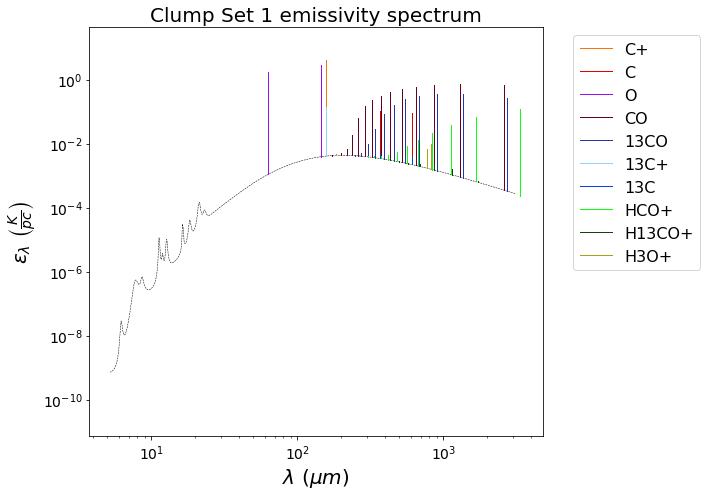

In [16]:
vox.plotSpectrum(quantity='emissivity')

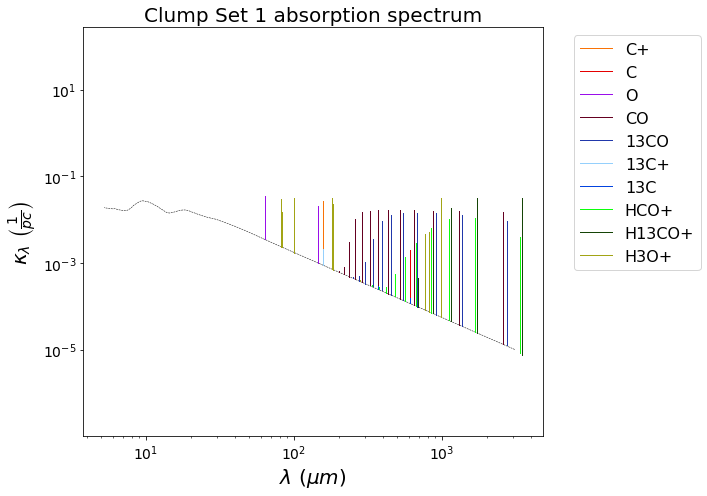

In [17]:
vox.plotSpectrum(quantity='absorption')

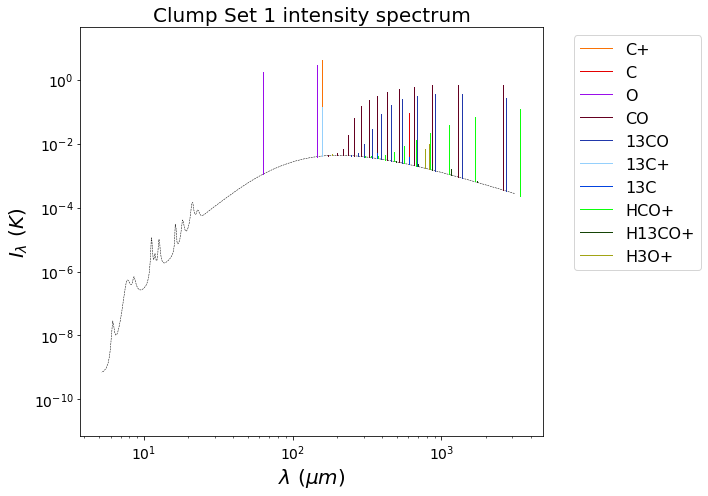

In [18]:
vox.plotSpectrum(quantity='intensity')

The molecular intensity and optical depth can be plotted against velocity, and this can be used to compare to the analytic result.

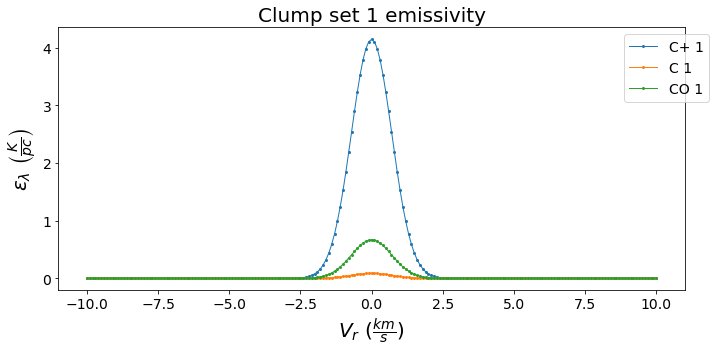

In [19]:
vox.plotMolecule(molecule=['C+ 1', 'C 1', 'CO 1'], quantity='emissivity', logscale=False)

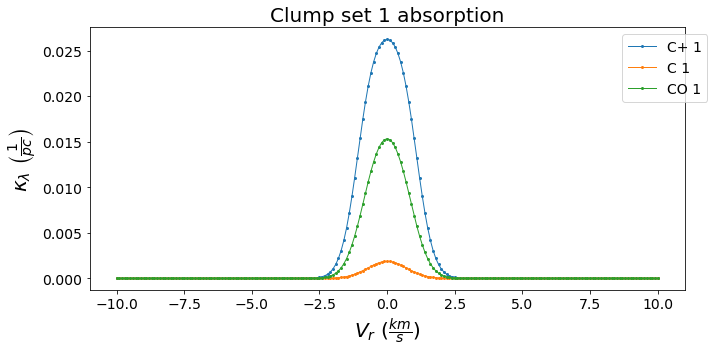

In [20]:
vox.plotMolecule(molecule=['C+ 1', 'C 1', 'CO 1'], quantity='absorption', logscale=False)

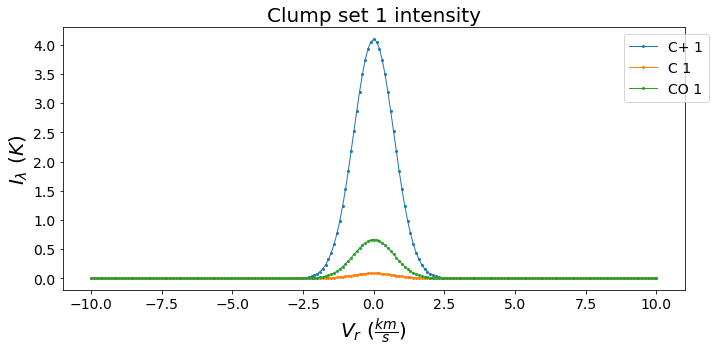

In [21]:
vox.plotMolecule(molecule=['C+ 1', 'C 1', 'CO 1'], quantity='intensity', logscale=False)

In [22]:
np.set_printoptions(precision=8)

In [23]:
molecules = ['dust 3.1mm', 'C+ 1', 'C 1', 'CO 1']
vox.getEmissivity()[0][100,models.species.speciesIndeces(molecules)] #for the first dust line and the first transition of C+, C, and CO

array([0.00027585, 4.14462714, 0.09132854, 0.66991168])

In [24]:
vox.getAbsorption()[0][100,models.species.speciesIndeces(molecules)] #for the first dust line and the first transition of C+, C, and CO

array([0.0000102 , 0.0262392 , 0.00187619, 0.015331  ])

In [25]:
vox.getIntensity()[0][100,models.species.speciesIndeces(molecules)] #for the first dust line and the first transition of C+, C, and CO

array([0.00027585, 4.09072379, 0.09124292, 0.66480261])

In [26]:
vox.getFUVabsorption()[0]

0.030913943210059658899

## Analytic result

So if we have one $10 M_\odot$ clump in the voxel, we can calculate the voxel-averaged intensity and optical depth for the 3.1 mm dust line and the first transition of C+, C, and CO. We should note that the clump radius is 0.07846164 pc, and the intensities and optical depths we consider are,

|               | 3.1mm dust line | C+ 1         | C 1        | CO 1        |
| ------------- | --------------- | ------------ | ---------- | ----------- |
| intensity     | 0.0152 K        | 178 K        | 5.05 K     | 36.1 K      |
| optical depth | 0.000528        | 1.86         | 0.0789     | 1.13        |

We now use this in to calculate the radiative transfer equation.

|           | 3.1mm dust line | C+ 1   | C 1      | CO 1    |
| --------- | --------------- | ------ | -------- | ------- |
| intensity | 0.000294 K      | 1.56 K | 0.0939 K | 0.418 K |

## 

# 2. Accounting for absorption

The object here is to show the effect of absorption when there are overlapping clumps in a line-of-sight.

## Model solution

Here we consider a larger voxel with larger mass, but we still consider a simple model with one clump mass. What we can show, for example, is how different clump sets can be created for the same voxel. The mass of dense clump component in the model is the same ($10 \ M_\odot$), but we are now modelling a larger ensemble mass of $10^4 M_\odot$, a high density of $10^6 cm^{-3}$, and FUV radiation $10^4 \chi_0$. The additional clump set we wish to include is the diffuse interclump component. We model this with $10^{-2} M_\odot$ clumps, ensemble mass $10^2 M_\odot$, density $1911 cm^{-3}$, and FUV radiation $1 \chi_0$.

In [41]:
from kosmatau3d import models
import numpy as np

np.set_printoptions(precision=8)

# Use these to change the voxel properties, which is necessary in the default mode.
parameters = { \
                # Model parameters
                'voxel_size' : 1, \
                 'molecules' : ['all'], \
                      'dust' : 'PAH', \
            'clumpMassRange' : [[1],[-2]], \
           'clumpMassNumber' : [1,1], \
                 'clumpNmax' : [1,100], \
             'velocityRange' : [-10, 10], \
            'velocityNumber' : 201, \

                # Voxel properties
                  'velocity' : 0., \
        'ensembleDispersion' : [1,1], \
                 'clumpMass' : [1e5,1e2], \
           'ensembleDensity' : [1e6,1911], \
                       'FUV' : [1e4,1] \
          }

vox = models.Voxel()
vox.setProperties(**parameters)
vox.calculateEmission(verbose=True)

Voxel emission calculated.


Now we can get some information needed for the theoretical solution.

In [42]:
vox.getClumpMass()

[100000.0, 100.0]

In [43]:
vox.getModelMass()

[99997.05455558008, 99.99705455558005]

In [44]:
models.masspoints.clumpRadius #in pc

[array([[0.04588465]]), array([[0.03697548]])]

In [45]:
molecules = ['dust 3.1mm', 'C+ 1', 'C 1', 'CO 1']
models.masspoints.clumpIntensity[0][:,models.species.speciesIndeces(molecules)] #for the 3.1mm dust line, C+, C, and CO; in K

array([[3.31657581e-02, 1.47947531e+02, 5.41450121e+00, 6.53316060e+01]])

In [46]:
models.masspoints.clumpOpticalDepth[0][:,models.species.speciesIndeces(molecules)] #for the 3.1mm dust line, C+, C, and CO

array([[1.54307913e-03, 1.20983436e+00, 3.88691335e-02, 2.54300691e+00]])

Finally, the intensity and optical depth of the single-voxel model is shown.

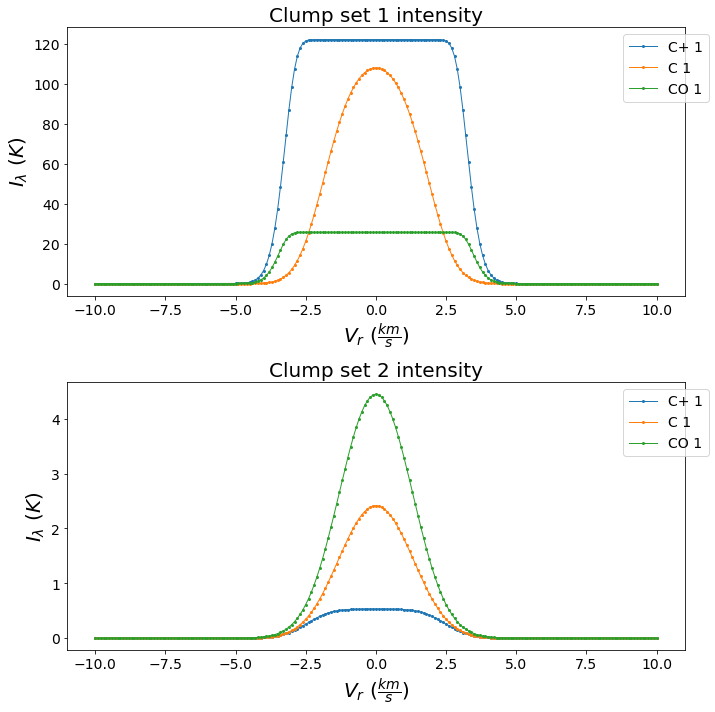

In [48]:
vox.plotMolecule(molecule=['C+ 1', 'C 1', 'CO 1'], quantity='intensity', title='', logscale=False)

In [54]:
vox.getFUVabsorption()

[inf, 26.201029763102605594]

In [55]:
molecules = ['dust 3.1mm', 'C+ 1', 'C 1', 'CO 1']
vox.getIntensity()[0][100,models.species.speciesIndeces(molecules)] #for the 3.1mm dust line, C+, C, and CO; in K

array([  2.0812, 122.2874, 108.1352,  25.6907])

In [56]:
vox.getEmissivity()[0][100,models.species.speciesIndeces(molecules)] #for the 3.1mm dust line, C+, C, and CO; in K/pc

array([   2.1889, 5699.2491,  208.5779, 2516.7105])

In [57]:
vox.getEmissivity()[0].shape

(201, 372)

In [58]:
vox.getAbsorption()[0][100,models.species.speciesIndeces(molecules)] #for the 3.1mm dust line, C+, C, and CO; in 1/pc

array([ 0.1018, 46.6054,  1.4973, 97.962 ])

In [59]:
molecules = ['dust 3.1mm', 'C+ 1', 'C 1', 'CO 1']
for i in range(2):
  
  print('\n\nC L U M P   S E T   {}\n'.format(i))
  
  eps_dust,eps_CII,eps_C,eps_CO = vox.getEmissivity()[i][:,models.species.speciesIndeces(molecules)].max(0)
  kap_dust,kap_CII,kap_C,kap_CO = vox.getAbsorption()[i][:,models.species.speciesIndeces(molecules)].max(0)

  #compute I via radiative transfer; in K
  I_dust = eps_dust/kap_dust * (1-np.exp(-kap_dust*models.constants.voxel_size))
  I_CII = eps_CII/kap_CII * (1-np.exp(-kap_CII*models.constants.voxel_size))
  I_C = eps_C/kap_C * (1-np.exp(-kap_C*models.constants.voxel_size))
  I_CO = eps_CO/kap_CO * (1-np.exp(-kap_CO*models.constants.voxel_size))

  print('The peak brightness temperature of dust at 3.1mm is {:.6f}'.format(I_dust))
  print('The peak brightness temperature of the first transition of C+ is {:.6f}'.format(I_CII))
  print('The peak brightness temperature of the first transition of C is {:.6f}'.format(I_C))
  print('The peak brightness temperature of the first transition of CO is {:.6f}'.format(I_CO))



C L U M P   S E T   0

The peak brightness temperature of dust at 3.1mm is 2.081165
The peak brightness temperature of the first transition of C+ is 122.287427
The peak brightness temperature of the first transition of C is 108.135191
The peak brightness temperature of the first transition of CO is 25.690692


C L U M P   S E T   1

The peak brightness temperature of dust at 3.1mm is 0.000821
The peak brightness temperature of the first transition of C+ is 0.533608
The peak brightness temperature of the first transition of C is 2.416468
The peak brightness temperature of the first transition of CO is 4.448949


## Analytic solution

### Clump Set 1

We now need to compare this result to the expected analytical intensity. Having a large number of clumps in the model means the probability of seeing a certain number of clumps is peaked in a narrow range. (ie. We can use this value to approximate the optical depth.) The probability mass distribution peaks at ~66, as seen below.

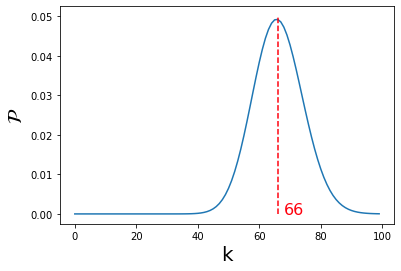

In [61]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt

rcl = models.masspoints.clumpRadius[0][0,0]
p = np.pi*rcl**2

k = np.arange(0,100)
prob = binom.pmf(k,1e4, p)
plt.plot(k, prob)
plt.plot([66,66], [0,0.05], ls='--', c='xkcd:bright red')
plt.text(68,0,'66',color='xkcd:bright red', fontsize=16)
plt.xlabel('k', fontsize=20)
plt.ylabel(r'$\mathcal{P}$', fontsize=20) ;

We can directly calculate the intensity that we would expect in such a voxel. With more than one clump in our line-of-sight, we will also need to account for the total amount of absorption in the voxel. We will need to calculate $\epsilon_{\nu,cl}$ and $\kappa_{\nu,cl}$ for the clump, which is constant.

(8)$$
\epsilon_{\nu, cl} = \frac{I_{\nu,cl}}{2R_{cl}}
$$

(9)$$
\kappa_{\nu, cl} = \frac{\tau_{\nu,cl}}{2R_{cl}}
$$

Now we can use these values to integrate the radiative equation:

(10)
$$
I_\nu = e^{-\int_0^{\Delta s} \kappa_{\nu,cl} ds} \left( \int_0^{\Delta s} \epsilon_{\nu,cl} e^{\int_0^{\Delta s} \kappa_{\nu,cl} s'} ds' + I_{bg} \right)
$$

Since the emission and absorption coefficients $\left( \epsilon_{\nu,cl}, \kappa_{\nu,cl} \right)$ are valid just in each clump, integration over $\mathcal{N}$ clumps with $I_{bg}=0$ gives,


(11)
$$
I_\nu = \frac{\epsilon_{\nu,cl}}{\kappa_{\nu,cl}} \left( 1 - e^{-\kappa_{\nu,cl} (2\mathcal{N}R_{cl})} \right)
$$

We can now analytically calculate what is the intensity of a given transition if we have 66 clumps in our line-of-sight.

In [64]:
# Define how many clumps are in a line-of-sight
nClumps = 66
# Get the clump radius
rcl = models.masspoints.clumpRadius[0][0,0]
# Specify transitions
molecules = ['dust 3.1mm', 'C+ 1', 'C 1', 'CO 1']
# get the clump intensity and optical depth for the required transitions
icl = models.masspoints.clumpIntensity[0][0,models.species.speciesIndeces(molecules)]
tcl = models.masspoints.clumpOpticalDepth[0][0,models.species.speciesIndeces(molecules)]

# Uncomment these if you would like to compare to the individual clump intensities
print('Clump intensities:')
for i,I in enumerate(icl/tcl*(1-np.exp(-tcl))):
  print('{:>10}: {:.6} K'.format(molecules[i], I))
print('\n')

# Initialise the line intensities
I = np.zeros(icl.size)

# Integrate over the number of clumps along a line-of-sight
# for i in range(nClumps):
#   I = np.exp(-tcl) * ( icl/tcl*(np.exp(tcl)-1) + I )
  
# Integrate in an alternate simplified equation
I = icl/tcl * (1-np.exp(-nClumps*tcl))

for i,transition in enumerate(molecules):
  print('The brightness temperature of the {:^10} transition is {:.6} K'.format(transition, I[i]))

Clump intensities:
dust 3.1mm: 0.0331402 K
      C+ 1: 85.8156 K
       C 1: 5.31062 K
      CO 1: 23.6706 K


The brightness temperature of the dust 3.1mm transition is 2.08117 K
The brightness temperature of the    C+ 1    transition is 122.287 K
The brightness temperature of the    C 1     transition is 128.59 K
The brightness temperature of the    CO 1    transition is 25.6907 K


These values are very similar to the results of the single-voxel model. The accurracy of this result is due to the large number of clumps in the voxel, giving a very specific number of clump in a line-of-sight. The difference between this result and the intensity of a single clump is larger for transitions with lower optical depth. That is how the CI and CII transitions get larger than that of a single clump; the background intensity has a larger effect.

There is also a difference between this analytic result and the one obtained with the single-voxel model in the CI transition. The issue here is the ensemble velocity dispersion in the single-voxel model. We gave it a velocity dispersion of $1 \frac{km}{s}$—very close to the intrinsic clump velocity dispersion of $0.71 \frac{km}{s}$—but even this is enough to ensure the $10^4$ clumps are actually spread over the ensemble velocities. In this way, it reduces the peak intensity of the voxel. The reason it only is seen in the CI transition is that it is not suffering from large absorption effects (you can see this by the lack of a plateau feature in the velocity-intensity plot seen earlier).

### Clump Set 2

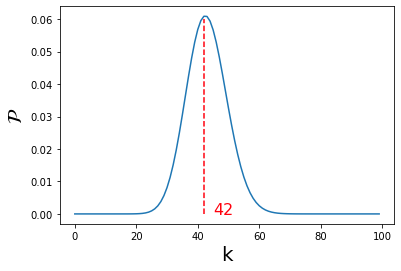

In [21]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt

rcl = models.masspoints.clumpRadius[1][0,0]
p = np.pi*rcl**2

k = np.arange(0,100)
prob = binom.pmf(k,1e4, p)
plt.plot(k, prob)
plt.plot([42,42], [0,0.06], ls='--', c='xkcd:bright red')
plt.text(45,0,'42',color='xkcd:bright red', fontsize=16)
plt.xlabel('k', fontsize=20)
plt.ylabel(r'$\mathcal{P}$', fontsize=20) ;

We can directly calculate the intensity that we would expect in such a voxel. With more than one clump in our line-of-sight, we will also need to account for the total amount of absorption in the voxel. We will need to calculate $\epsilon_{\nu,cl}$ and $\kappa_{\nu,cl}$ for the clump, which is constant.

(8)$$
\epsilon_{\nu, cl} = \frac{I_{\nu,cl}}{2R_{cl}}
$$

(9)$$
\kappa_{\nu, cl} = \frac{\tau_{\nu,cl}}{2R_{cl}}
$$

Now we can use these values to integrate the radiative equation:

(10)
$$
I_\nu = e^{-\int_0^{\Delta s} \kappa_{\nu,cl} ds} \left( \int_0^{\Delta s} \epsilon_{\nu,cl} e^{\int_0^{\Delta s} \kappa_{\nu,cl} s'} ds' + I_{bg} \right)
$$

Since the emission and absorption coefficients $\left( \epsilon_{\nu,cl}, \kappa_{\nu,cl} \right)$ are valid just in each clump, integration over $\mathcal{N}$ clumps with $I_{bg}=0$ gives,


(11)
$$
I_\nu = \frac{\epsilon_{\nu,cl}}{\kappa_{\nu,cl}} \left( 1 - e^{-\kappa_{\nu,cl} (2\mathcal{N}R_{cl})} \right)
$$

We can now analytically calculate what is the intensity of a given transition if we have 66 clumps in our line-of-sight.

In [67]:
# Define how many clumps are in a line-of-sight
nClumps = 42
# Get the clump radius
rcl = models.masspoints.clumpRadius[0][0,0]
# Specify transitions
molecules = ['dust 3.1mm', 'C+ 1', 'C 1', 'CO 1']
# get the clump intensity and optical depth for the required transitions
icl = models.masspoints.clumpIntensity[1][0,models.species.speciesIndeces(molecules)]
tcl = models.masspoints.clumpOpticalDepth[1][0,models.species.speciesIndeces(molecules)]

# Uncomment these to view the clump intensities
# print('Clump intensities:')
# for i,I in enumerate(icl/tcl*(1-np.exp(-tcl))):
#   print('{:>10}: {:.6} K'.format(molecules[i], I))
# print('\n')

# Initialise the line intensities
I = np.zeros(icl.size)

# Integrate over the number of clumps along a line-of-sight
# for i in range(nClumps):
#   I = np.exp(-tcl) * ( icl/tcl*(np.exp(tcl)-1) + I )
  
# Integrate in an alternate simplified equation
I = icl/tcl * (1-np.exp(-nClumps*tcl))

for i,transition in enumerate(molecules):
  print('The brightness temperature of the {:^10} transition is {:.6} K'.format(transition, I[i]))

The brightness temperature of the dust 3.1mm transition is 0.000805802 K
The brightness temperature of the    C+ 1    transition is 0.493531 K
The brightness temperature of the    C 1     transition is 3.67862 K
The brightness temperature of the    CO 1    transition is 6.9607 K


Like in the previous clump set, these values are very similar to the results of the single-voxel model. The accurracy of this result is due to the large number of clumps in the voxel, giving a very specific number of clump in a line-of-sight.

This time the difference between the analytic result and the one obtained with the single-voxel model is due primarily to the ensemble velocity dispersion. We gave it a velocity dispersion of $1 \frac{km}{s}$—very close to the intrinsic clump velocity dispersion of $0.71 \frac{km}{s}$—but even this is enough to ensure the $10^4$ clumps are actually spread over the ensemble velocities. In this way, it reduces the peak intensity of the voxel. It is seen in the CI and CO transitions since they are not suffering from large absorption effects (you can see this by the lack of a plateau feature in the velocity-intensity plot seen earlier).

# 

# 3. Changing the velocity dispersion in the voxel

Here we will consider two voxel with similar properties except for the ensemble dispersion. Thus we will examine the how the velocity dispersion affects the resulting intensity.

Voxel emission calculated.


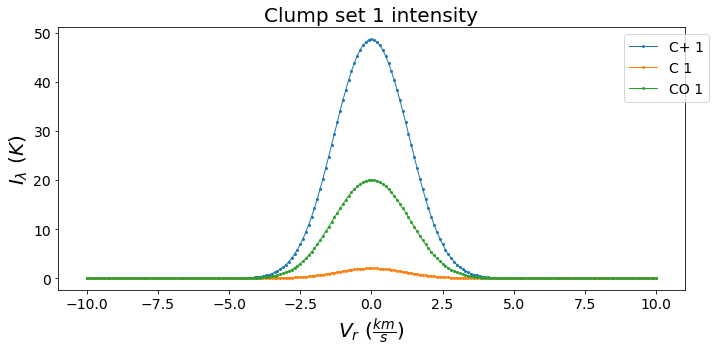

In [2]:
from kosmatau3d import models
import numpy as np

np.set_printoptions(precision=8)

# Use these to change the voxel properties, which is necessary in the default mode.
parameters = { \
                # Model parameters
                'voxel_size' : 1, \
                 'molecules' : 'all', \
                      'dust' : 'PAH', \
            'clumpMassRange' : [[1]], \
           'clumpMassNumber' : [1], \
                 'clumpNmax' : [1], \
             'velocityRange' : [-10, 10], \
            'velocityNumber' : 201, \

                # Voxel properties
                  'velocity' : 0., \
        'ensembleDispersion' : 1, \
                 'clumpMass' : 1e3, \
           'ensembleDensity' : 1e6, \
                       'FUV' : 1e4 \
          }

vox = models.Voxel()
vox.setProperties(**parameters)
vox.calculateEmission(verbose=True)
vox.plotMolecule(molecule=['C+ 1', 'C 1', 'CO 1'])

Voxel emission calculated.


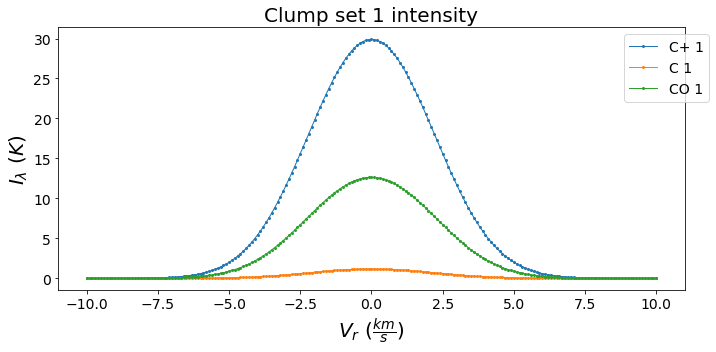

In [3]:
from kosmatau3d import models
import numpy as np

np.set_printoptions(precision=8)

# Use these to change the voxel properties, which is necessary in the default mode.
parameters = { \
                # Model parameters
                'voxel_size' : 1, \
                 'molecules' : 'all', \
                      'dust' : 'PAH', \
            'clumpMassRange' : [[1]], \
           'clumpMassNumber' : [1], \
                 'clumpNmax' : [1], \
             'velocityRange' : [-10, 10], \
            'velocityNumber' : 201, \

                # Voxel properties
                  'velocity' : 0., \
        'ensembleDispersion' : 2, \
                 'clumpMass' : 1e3, \
           'ensembleDensity' : 1e6, \
                       'FUV' : 1e4 \
          }

vox = models.Voxel()
vox.setProperties(**parameters)
vox.calculateEmission(verbose=True)
vox.plotMolecule(molecule=['C+ 1', 'C 1', 'CO 1'])

## 

# 4. Resizing the voxel

### Small clumps

Here we consider a voxel with larger mass and more observed velocities, but we still consider a simple model with one clump mass. The mass clump this time is much smaller ($10^{-2} \ M_\odot$). This is the typical clump size used to model the interclump medium. Andree-Labsch (2017) models the interclump medium by forcing $\mathrm{n}_{max}=100$ (this is called `clumpNmax` in the single-voxel model). As you might have seen, specifying `clumpNmax` will normalise the number of clumps in the model to that value by scaling the voxel size. Using a value of None will not use this feature. We can model $10^2 M_\odot$ in the voxel, but vary $\mathrm{n}_{max} \in (100,1,None)$. This example will be used to examine the validity of this normalisation and rescaling of the voxel.

Voxel emission calculated.
Peak intensities for  ['C+ 1', 'C 1', 'CO 1']
[16.39898717  0.43592932  4.13836961]


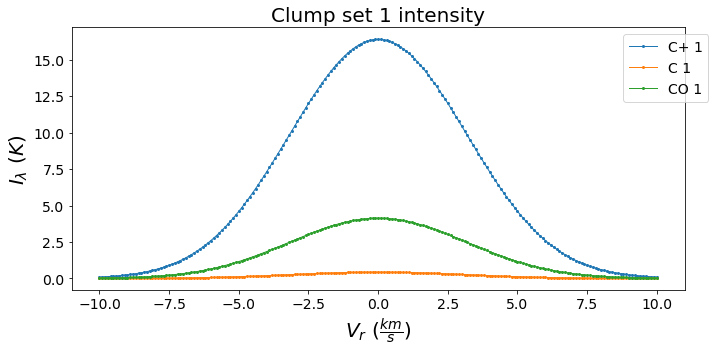

In [5]:
from kosmatau3d import models
import numpy as np

# Use these to change the voxel properties, which is necessary in the default mode.
parameters = { \
                # Model parameters
                'voxel_size' : 1, \
                 'molecules' : 'all', \
                      'dust' : 'PAH', \
            'clumpMassRange' : [[-2]], \
           'clumpMassNumber' : [1], \
                 'clumpNmax' : [100], \
             'velocityRange' : [-10, 10], \
            'velocityNumber' : 201, \

                # Voxel properties
                  'velocity' : 0., \
        'ensembleDispersion' : 3, \
                 'clumpMass' : 1e2, \
           'ensembleDensity' : 1e6, \
                       'FUV' : 1e4 \
          }

vox = models.Voxel()
vox.setProperties(**parameters)
vox.calculateEmission(verbose=True)

molecules = ['C+ 1', 'C 1', 'CO 1']
print('Peak intensities for ', molecules)
print(vox.getIntensity()[0][:,models.species.speciesIndeces(molecules)].max(0))
vox.plotMolecule(molecule=molecules)

In [6]:
models.ensemble.printEnsembleParameters()


C L U M P   S E T   1

Nj:
[[10000.]]
delta Nji:
[[  0.1409]
 [  0.2134]
 [  0.3198]
 [  0.474 ]
 [  0.6947]
 [  1.0069]
 [  1.4434]
 [  2.0463]
 [  2.869 ]
 [  3.9782]
 [  5.4555]
 [  7.3989]
 [  9.924 ]
 [ 13.1643]
 [ 17.2701]
 [ 22.4067]
 [ 28.7509]
 [ 36.4848]
 [ 45.789 ]
 [ 56.8326]
 [ 69.7625]
 [ 84.6904]
 [101.6797]
 [120.7319]
 [141.7745]
 [164.65  ]
 [189.1095]
 [214.8091]
 [241.3127]
 [268.0991]
 [294.5767]
 [320.1027]
 [344.0077]
 [365.6241]
 [384.3169]
 [399.5139]
 [410.7355]
 [417.6191]
 [419.9392]
 [417.6191]
 [410.7355]
 [399.5139]
 [384.3169]
 [365.6241]
 [344.0077]
 [320.1027]
 [294.5767]
 [268.0991]
 [241.3127]
 [214.8091]
 [189.1095]
 [164.65  ]
 [141.7745]
 [120.7319]
 [101.6797]
 [ 84.6904]
 [ 69.7625]
 [ 56.8326]
 [ 45.789 ]
 [ 36.4848]
 [ 28.7509]
 [ 22.4067]
 [ 17.2701]
 [ 13.1643]
 [  9.924 ]
 [  7.3989]
 [  5.4555]
 [  3.9782]
 [  2.869 ]
 [  2.0463]
 [  1.4434]
 [  1.0069]
 [  0.6947]
 [  0.474 ]
 [  0.3198]
 [  0.2134]
 [  0.1409]]

Normalised Nj:
[[100.]]


Voxel emission calculated.
Peak intensities for  ['C+ 1', 'C 1', 'CO 1']
[16.8218  0.4476  4.2456]


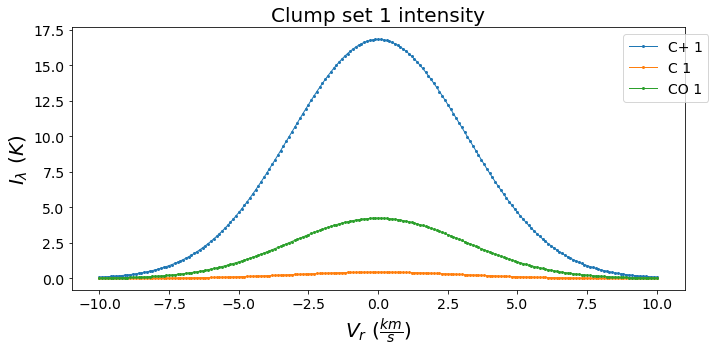

In [7]:
from kosmatau3d import models
import numpy as np

# Use these to change the voxel properties, which is necessary in the default mode.
parameters = { \
                # Model parameters
                'voxel_size' : 1, \
                 'molecules' : 'all', \
                      'dust' : 'PAH', \
            'clumpMassRange' : [[-2]], \
           'clumpMassNumber' : [1], \
                 'clumpNmax' : [1], \
             'velocityRange' : [-10, 10], \
            'velocityNumber' : 201, \

                # Voxel properties
                  'velocity' : 0., \
        'ensembleDispersion' : 3, \
                 'clumpMass' : 1e2, \
           'ensembleDensity' : 1e6, \
                       'FUV' : 1e4 \
          }

vox = models.Voxel()
vox.setProperties(**parameters)
vox.calculateEmission(verbose=True)

molecules = ['C+ 1', 'C 1', 'CO 1']
print('Peak intensities for ', molecules)
print(vox.getIntensity()[0][:,models.species.speciesIndeces(molecules)].max(0))
vox.plotMolecule(molecule=molecules)

In [8]:
models.ensemble.printEnsembleParameters()


C L U M P   S E T   1

Nj:
[[10000.]]
delta Nji:
[[  0.1409]
 [  0.2134]
 [  0.3198]
 [  0.474 ]
 [  0.6947]
 [  1.0069]
 [  1.4434]
 [  2.0463]
 [  2.869 ]
 [  3.9782]
 [  5.4555]
 [  7.3989]
 [  9.924 ]
 [ 13.1643]
 [ 17.2701]
 [ 22.4067]
 [ 28.7509]
 [ 36.4848]
 [ 45.789 ]
 [ 56.8326]
 [ 69.7625]
 [ 84.6904]
 [101.6797]
 [120.7319]
 [141.7745]
 [164.65  ]
 [189.1095]
 [214.8091]
 [241.3127]
 [268.0991]
 [294.5767]
 [320.1027]
 [344.0077]
 [365.6241]
 [384.3169]
 [399.5139]
 [410.7355]
 [417.6191]
 [419.9392]
 [417.6191]
 [410.7355]
 [399.5139]
 [384.3169]
 [365.6241]
 [344.0077]
 [320.1027]
 [294.5767]
 [268.0991]
 [241.3127]
 [214.8091]
 [189.1095]
 [164.65  ]
 [141.7745]
 [120.7319]
 [101.6797]
 [ 84.6904]
 [ 69.7625]
 [ 56.8326]
 [ 45.789 ]
 [ 36.4848]
 [ 28.7509]
 [ 22.4067]
 [ 17.2701]
 [ 13.1643]
 [  9.924 ]
 [  7.3989]
 [  5.4555]
 [  3.9782]
 [  2.869 ]
 [  2.0463]
 [  1.4434]
 [  1.0069]
 [  0.6947]
 [  0.474 ]
 [  0.3198]
 [  0.2134]
 [  0.1409]]

Normalised Nj:
[[1.]]
No

Voxel emission calculated.
Peak intensities for  ['C+ 1', 'C 1', 'CO 1']
[16.4054  0.4361  4.14  ]


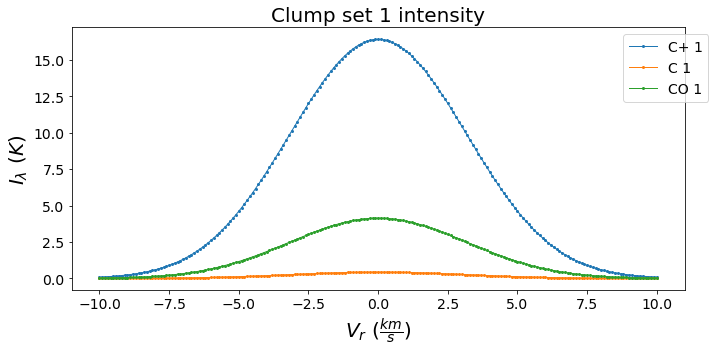

In [9]:
from kosmatau3d import models
import numpy as np

# Use these to change the voxel properties, which is necessary in the default mode.
parameters = { \
                # Model parameters
                'voxel_size' : 1, \
                 'molecules' : 'all', \
                      'dust' : 'PAH', \
            'clumpMassRange' : [[-2]], \
           'clumpMassNumber' : [1], \
                 'clumpNmax' : [None], \
             'velocityRange' : [-10, 10], \
            'velocityNumber' : 201, \

                # Voxel properties
                  'velocity' : 0., \
        'ensembleDispersion' : 3, \
                 'clumpMass' : 1e2, \
           'ensembleDensity' : 1e6, \
                       'FUV' : 1e4 \
          }

vox = models.Voxel()
vox.setProperties(**parameters)
vox.calculateEmission(verbose=True)

molecules = ['C+ 1', 'C 1', 'CO 1']
print('Peak intensities for ', molecules)
print(vox.getIntensity()[0][:,models.species.speciesIndeces(molecules)].max(0))
vox.plotMolecule(molecule=molecules)

In [10]:
models.ensemble.printEnsembleParameters()


C L U M P   S E T   1

Nj:
[[10000.]]
delta Nji:
[[  0.1409]
 [  0.2134]
 [  0.3198]
 [  0.474 ]
 [  0.6947]
 [  1.0069]
 [  1.4434]
 [  2.0463]
 [  2.869 ]
 [  3.9782]
 [  5.4555]
 [  7.3989]
 [  9.924 ]
 [ 13.1643]
 [ 17.2701]
 [ 22.4067]
 [ 28.7509]
 [ 36.4848]
 [ 45.789 ]
 [ 56.8326]
 [ 69.7625]
 [ 84.6904]
 [101.6797]
 [120.7319]
 [141.7745]
 [164.65  ]
 [189.1095]
 [214.8091]
 [241.3127]
 [268.0991]
 [294.5767]
 [320.1027]
 [344.0077]
 [365.6241]
 [384.3169]
 [399.5139]
 [410.7355]
 [417.6191]
 [419.9392]
 [417.6191]
 [410.7355]
 [399.5139]
 [384.3169]
 [365.6241]
 [344.0077]
 [320.1027]
 [294.5767]
 [268.0991]
 [241.3127]
 [214.8091]
 [189.1095]
 [164.65  ]
 [141.7745]
 [120.7319]
 [101.6797]
 [ 84.6904]
 [ 69.7625]
 [ 56.8326]
 [ 45.789 ]
 [ 36.4848]
 [ 28.7509]
 [ 22.4067]
 [ 17.2701]
 [ 13.1643]
 [  9.924 ]
 [  7.3989]
 [  5.4555]
 [  3.9782]
 [  2.869 ]
 [  2.0463]
 [  1.4434]
 [  1.0069]
 [  0.6947]
 [  0.474 ]
 [  0.3198]
 [  0.2134]
 [  0.1409]]

Normalised Nj:
[[10000.]

As we can see here, changing $\mathrm{n}_{max}$ has little effect on the resulting intensity of the voxel $(< 5 \%)$. The main motivation for specifying $\mathrm{n}_{max}$ is a computational one: it limits the number of clump combinations calculated and thus the computational footprint of the model.

### Large clumps

One reason the test using $10^{-2} M_\odot$ did not show much of a difference using different $\mathrm{n}_{max}$ is that there is not much absorption in such a small clump mass. We can thus repeat this experiment for a more massive clump of $10 M_\odot$. In this case we use an ensemble mass of $10^3 M_\odot$ to ensure the voxel still has enough clumps to suffer from self-absorption but not so many to be completely self-absorbed (seen by a plateau in the velocity-intensity plot).

Voxel emission calculated.
Peak intensities for  ['C+ 1', 'C 1', 'CO 1']
[46.7233  1.9619 19.3336]


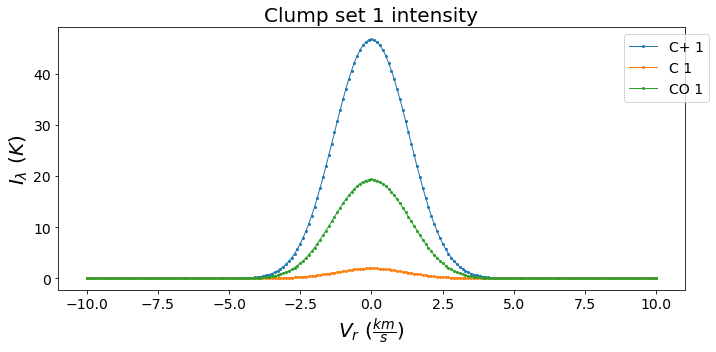

In [11]:
from kosmatau3d import models
import numpy as np

# Use these to change the voxel properties, which is necessary in the default mode.
parameters = { \
                # Model parameters
                'voxel_size' : 1, \
                 'molecules' : 'all', \
                      'dust' : 'PAH', \
            'clumpMassRange' : [[1]], \
           'clumpMassNumber' : [1], \
                 'clumpNmax' : [3], \
             'velocityRange' : [-10, 10], \
            'velocityNumber' : 201, \

                # Voxel properties
                  'velocity' : 0., \
        'ensembleDispersion' : 1, \
                 'clumpMass' : 1e3, \
           'ensembleDensity' : 1e6, \
                       'FUV' : 1e4 \
          }

vox = models.Voxel()
vox.setProperties(**parameters)
vox.calculateEmission(verbose=True)

molecules = ['C+ 1', 'C 1', 'CO 1']
print('Peak intensities for ', molecules)
print(vox.getIntensity()[0][:,models.species.speciesIndeces(molecules)].max(0))
vox.plotMolecule(molecule=molecules)

In [12]:
models.ensemble.printEnsembleParameters()


C L U M P   S E T   1

Nj:
[[100.]]
delta Nji:
[[ 0.0043]
 [ 0.0146]
 [ 0.0451]
 [ 0.1257]
 [ 0.3159]
 [ 0.7166]
 [ 1.4676]
 [ 2.7128]
 [ 4.5267]
 [ 6.8182]
 [ 9.2701]
 [11.377 ]
 [12.6038]
 [12.6038]
 [11.377 ]
 [ 9.2701]
 [ 6.8182]
 [ 4.5267]
 [ 2.7128]
 [ 1.4676]
 [ 0.7166]
 [ 0.3159]
 [ 0.1257]
 [ 0.0451]
 [ 0.0146]
 [ 0.0043]]

Normalised Nj:
[[3.]]
Normalised delta Nj:
[[3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]]



Voxel emission calculated.
Peak intensities for  ['C+ 1', 'C 1', 'CO 1']
[48.6623  2.0566 20.0793]


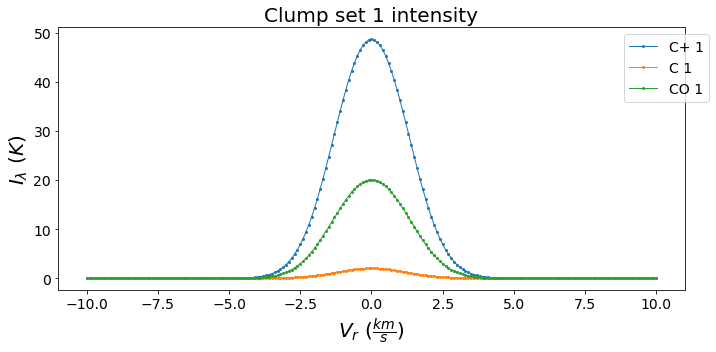

In [13]:
from kosmatau3d import models
import numpy as np

# Use these to change the voxel properties, which is necessary in the default mode.
parameters = { \
                # Model parameters
                'voxel_size' : 1, \
                 'molecules' : 'all', \
                      'dust' : 'PAH', \
            'clumpMassRange' : [[1]], \
           'clumpMassNumber' : [1], \
                 'clumpNmax' : [1], \
             'velocityRange' : [-10, 10], \
            'velocityNumber' : 201, \

                # Voxel properties
                  'velocity' : 0., \
        'ensembleDispersion' : 1, \
                 'clumpMass' : 1e3, \
           'ensembleDensity' : 1e6, \
                       'FUV' : 1e4 \
          }

vox = models.Voxel()
vox.setProperties(**parameters)
vox.calculateEmission(verbose=True)

molecules = ['C+ 1', 'C 1', 'CO 1']
print('Peak intensities for ', molecules)
print(vox.getIntensity()[0][:,models.species.speciesIndeces(molecules)].max(0))
vox.plotMolecule(molecule=molecules)

In [14]:
models.ensemble.printEnsembleParameters()


C L U M P   S E T   1

Nj:
[[100.]]
delta Nji:
[[ 0.0043]
 [ 0.0146]
 [ 0.0451]
 [ 0.1257]
 [ 0.3159]
 [ 0.7166]
 [ 1.4676]
 [ 2.7128]
 [ 4.5267]
 [ 6.8182]
 [ 9.2701]
 [11.377 ]
 [12.6038]
 [12.6038]
 [11.377 ]
 [ 9.2701]
 [ 6.8182]
 [ 4.5267]
 [ 2.7128]
 [ 1.4676]
 [ 0.7166]
 [ 0.3159]
 [ 0.1257]
 [ 0.0451]
 [ 0.0146]
 [ 0.0043]]

Normalised Nj:
[[1.]]
Normalised delta Nj:
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]



Voxel emission calculated.
Peak intensities for  ['C+ 1', 'C 1', 'CO 1']
[46.1343  1.9333 19.1036]


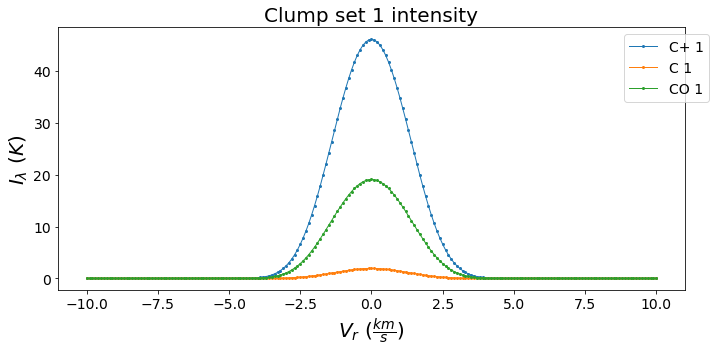

In [15]:
from kosmatau3d import models
import numpy as np

# Use these to change the voxel properties, which is necessary in the default mode.
parameters = { \
                # Model parameters
                'voxel_size' : 1, \
                 'molecules' : 'all', \
                      'dust' : 'PAH', \
            'clumpMassRange' : [[1]], \
           'clumpMassNumber' : [1], \
                 'clumpNmax' : [None], \
             'velocityRange' : [-10, 10], \
            'velocityNumber' : 201, \

                # Voxel properties
                  'velocity' : 0., \
        'ensembleDispersion' : 1, \
                 'clumpMass' : 1e3, \
           'ensembleDensity' : 1e6, \
                       'FUV' : 1e4 \
          }

vox = models.Voxel()
vox.setProperties(**parameters)
vox.calculateEmission(verbose=True)

molecules = ['C+ 1', 'C 1', 'CO 1']
print('Peak intensities for ', molecules)
print(vox.getIntensity()[0][:,models.species.speciesIndeces(molecules)].max(0))
vox.plotMolecule(molecule=molecules)

In [17]:
models.ensemble.printEnsembleParameters()


C L U M P   S E T   1

Nj:
[[100.]]
delta Nji:
[[ 0.0043]
 [ 0.0146]
 [ 0.0451]
 [ 0.1257]
 [ 0.3159]
 [ 0.7166]
 [ 1.4676]
 [ 2.7128]
 [ 4.5267]
 [ 6.8182]
 [ 9.2701]
 [11.377 ]
 [12.6038]
 [12.6038]
 [11.377 ]
 [ 9.2701]
 [ 6.8182]
 [ 4.5267]
 [ 2.7128]
 [ 1.4676]
 [ 0.7166]
 [ 0.3159]
 [ 0.1257]
 [ 0.0451]
 [ 0.0146]
 [ 0.0043]]

Normalised Nj:
[[100.]]
Normalised delta Nj:
[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 3.]
 [ 5.]
 [ 7.]
 [ 9.]
 [11.]
 [13.]
 [13.]
 [11.]
 [ 9.]
 [ 7.]
 [ 5.]
 [ 3.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]



The difference here can approach $5 \%$. This difference, while not much, should be kept in mind when using the single-voxel model. This error is also most evident in models with enough clumps for self absorption, but not so many that a plateau appears in the velocity-intensity plot. In cases that feature a plateau, this error is mitigated.

# 

# 5. Dense voxel with multiple clump masses

Having shown the functionality of using one clump in the model, we now reepeat the previous example using clump masses $0.1$, $1$, and $10 \ M_\odot$ in the model. What we will see is that there is a similar intensity and optical depth. Note the change in `clumpMassRange` and `clumpMassNumber` kwargs.

In [42]:
from kosmatau3d import models
import numpy as np

# Use these to change the voxel properties, which is necessary in the default mode.
parameters = { \
                # Model parameters
                'voxel_size' : 0.1, \
                 'molecules' : ['C+ 1', 'C 1', 'CO 1', '13C+ 1', '13C 1', '13CO 1'], \
                      'dust' : 'PAH', \
            'clumpMassRange' : [[0, 2]], \
           'clumpMassNumber' : [3], \
                 'clumpNmax' : [1], \
             'velocityRange' : [-2, 2], \
            'velocityNumber' : 21, \

                # Voxel properties
                  'velocity' : 0., \
        'ensembleDispersion' : 3, \
                 'clumpMass' : 100, \
           'ensembleDensity' : 15000, \
                       'FUV' : 20000 \
          }

vox = models.Voxel()
vox.setProperties(**parameters)
vox.calculateEmission()

It is worth examining how the number of clumps at each velocity is normalised for each clump mass. For multiple clumps, the largest clump is shown in the last column.

In [43]:
models.ensemble.printEnsembleParameters()


C L U M P   S E T   1

Nj:
[[22.052   3.1875  0.4607]]
delta Nji:
[[0.     0.     0.    ]
 [0.0002 0.     0.    ]
 [0.0014 0.0002 0.    ]
 [0.0093 0.0013 0.0002]
 [0.0478 0.0069 0.001 ]
 [0.1906 0.0275 0.004 ]
 [0.5906 0.0854 0.0123]
 [1.4233 0.2057 0.0297]
 [2.668  0.3856 0.0557]
 [3.8896 0.5622 0.0813]
 [4.4104 0.6375 0.0921]
 [3.8896 0.5622 0.0813]
 [2.668  0.3856 0.0557]
 [1.4233 0.2057 0.0297]
 [0.5906 0.0854 0.0123]
 [0.1906 0.0275 0.004 ]
 [0.0478 0.0069 0.001 ]
 [0.0093 0.0013 0.0002]
 [0.0014 0.0002 0.    ]
 [0.0002 0.     0.    ]
 [0.     0.     0.    ]]

Normalised Nj:
[[1483.7533  214.4676   31.    ]]
Normalised delta Nj:
[[  0.       0.       0.    ]
 [ 47.863    6.9183   1.    ]
 [ 47.863    6.9183   1.    ]
 [ 47.863    6.9183   1.    ]
 [ 47.863    6.9183   1.    ]
 [ 47.863    6.9183   1.    ]
 [ 47.863    6.9183   1.    ]
 [ 95.726   13.8366   2.    ]
 [191.452   27.6732   4.    ]
 [287.1781  41.5099   6.    ]
 [335.0411  48.4282   7.    ]
 [287.1781  41.5099   6.   

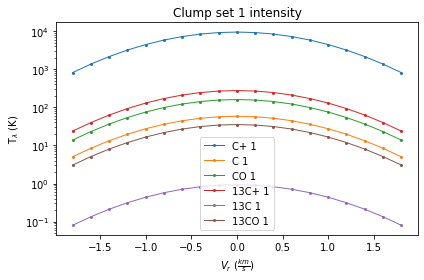

In [27]:
vox.plotMolecule(molecule='', quantity='intensity', logscale=True)

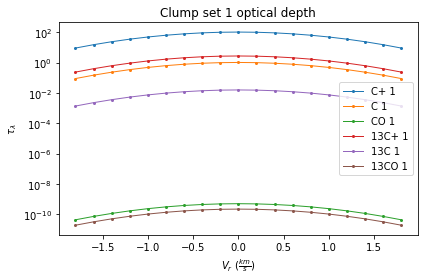

In [28]:
vox.plotMolecule(molecule='', quantity='optical depth', logscale=True)

The strange result of the $13C \ 1 \rightarrow 0$ optical depth needs a bit more explanation. (pending...)

# 

# 6. Dense voxel with multiple clump masses

Finally we can see how changing the voxel parameters appropriately can give the same result. We will use the same model parameters as the previous example with a larger voxel size. If we increase the Voxel size to $1 pc$ (a factor of 10 greater) and increase the mass to $10 \ 000 M_\odot$ (a factor of 100 greater), we should get the same results as the previous example.

In [46]:
from kosmatau3d import models
import numpy as np

# Use these to change the voxel properties, which is necessary in the default mode.
parameters = { \
                # Model parameters
                'voxel_size' : 1, \
                 'molecules' : ['C+ 1', 'C 1', 'CO 1', '13C+ 1', '13C 1', '13CO 1'], \
                      'dust' : 'PAH', \
            'clumpMassRange' : [[0, 2]], \
           'clumpMassNumber' : [3], \
                 'clumpNmax' : [1], \
             'velocityRange' : [-2, 2], \
            'velocityNumber' : 21, \

                # Voxel properties
                  'velocity' : 0., \
        'ensembleDispersion' : 3, \
                 'clumpMass' : 10000, \
           'ensembleDensity' : 15000, \
                       'FUV' : 20000 \
          }

vox = models.Voxel()
vox.setProperties(**parameters)
vox.calculateEmission()

It is worth examining how the number of clumps at each velocity is normalised for each clump mass. For multiple clumps, the largest clump is shown in the last column.

In [47]:
models.ensemble.printEnsembleParameters()


C L U M P   S E T   1

Nj:
[[2205.2001  318.7484   46.0732]]
delta Nji:
[[  0.0015   0.0002   0.    ]
 [  0.0167   0.0024   0.0003]
 [  0.1418   0.0205   0.003 ]
 [  0.9339   0.135    0.0195]
 [  4.7838   0.6915   0.0999]
 [ 19.0591   2.7549   0.3982]
 [ 59.0578   8.5364   1.2339]
 [142.332   20.5732   2.9737]
 [266.7951  38.5636   5.5741]
 [388.9582  56.2216   8.1265]
 [441.04    63.7497   9.2146]
 [388.9582  56.2216   8.1265]
 [266.7951  38.5636   5.5741]
 [142.332   20.5732   2.9737]
 [ 59.0578   8.5364   1.2339]
 [ 19.0591   2.7549   0.3982]
 [  4.7838   0.6915   0.0999]
 [  0.9339   0.135    0.0195]
 [  0.1418   0.0205   0.003 ]
 [  0.0167   0.0024   0.0003]
 [  0.0015   0.0002   0.    ]]

Normalised Nj:
[[1483.7533  214.4676   31.    ]]
Normalised delta Nj:
[[  0.       0.       0.    ]
 [ 47.863    6.9183   1.    ]
 [ 47.863    6.9183   1.    ]
 [ 47.863    6.9183   1.    ]
 [ 47.863    6.9183   1.    ]
 [ 47.863    6.9183   1.    ]
 [ 47.863    6.9183   1.    ]
 [ 95.726   13.

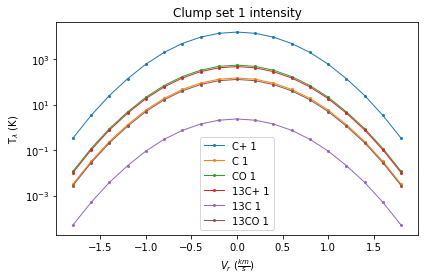

In [48]:
vox.plotMolecule(molecule='', quantity='intensity', logscale=True)

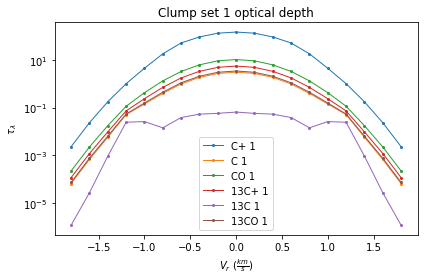

In [49]:
vox.plotMolecule(molecule='', quantity='optical depth', logscale=True)

Indeed the same results are present in this model as well. Since we do not change the model clumps, the voxel density, or FUV field, this should be expected by comparing the results of `ensemble.printEnsembleParameters()`. In the end, this just verifies the validity of rescaling the voxel.